# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [68]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [94]:
# Add any additional import statements you need here

from nltk.tokenize import word_tokenize
import emoji
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
# change `data_location` to the location of the folder on your machine.
data_location = '/users/christophergarcia/Desktop/ads-tm-api-scrape/'

# These subfolders should still work if you correctly stored the 
twitter_folder = 'twitter/'
lyrics_folder = 'lyrics/'
artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

positive_words_file = '/Users/christophergarcia/Downloads/positive-words.txt'
negative_words_file = '/Users/christophergarcia/Downloads/negative-words.txt'
tidy_text_file = '/Users/christophergarcia/Downloads/tidytext_sentiments.txt'

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [71]:
# Read Twitter Data
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)

twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

twitter_data = twitter_data[['artist', 'description']]
twitter_data.head(2)

,artist,description
0,cher,NaN
1,cher,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜


In [72]:
# Read Lyrics Data
def create_lyrics_dictionary(folder_path):
    lyrics_dict = {}

    # Iterate over each item in the folder
    for item_name in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item_name)

        # Check if the item is a folder (artist folder)
        if os.path.isdir(item_path):
            artist_dict = {}

            # Iterate over each file in the artist folder
            for filename in os.listdir(item_path):
                file_path = os.path.join(item_path, filename)

                # Check if the item is a file (song file)
                if os.path.isfile(file_path):
                    with open(file_path, "r") as file:
                        # Read the contents of the file
                        lines = file.readlines()

                        if lines:
                            title = lines[0].strip()  # Assuming the first line contains the title
                            lyrics = ''.join(lines[1:])  # Combine the remaining lines as the lyrics

                            # Add the song lyrics to the artist's dictionary with the title as the inner key
                            artist_dict[title] = lyrics

            # Add the artist's dictionary to the main lyrics dictionary
            lyrics_dict[item_name] = artist_dict

    return lyrics_dict

# Call the function with the lyrics folder path
lyrics_dictionary = create_lyrics_dictionary(data_location + lyrics_folder)

In [73]:
# Create an empty list to store the rows of the DataFrame
rows = []

# Iterate over the dictionary
for artist, songs in lyrics_dictionary.items():
    for song, lyrics in songs.items():
        # Remove double quotation marks from the song name
        song = song.replace('"', '')
        lyrics = lyrics.replace('\n', ' ')
        # Append a new row to the list
        rows.append({
            'artist': artist,
            'song': song,
            'lyrics': lyrics
        })

# Create the DataFrame from the list of rows
lyrics_data = pd.DataFrame(rows, columns=['artist', 'song', 'lyrics'])

In [74]:
lyrics_data.head()

,artist,song,lyrics
0,robyn,Include Me Out,It is really very simple Just a single puls...
1,robyn,Electric,Electric... It's electric It's a natural h...
2,robyn,Beach 2K20,(So you wanna go out? How you gonna get the...
3,robyn,Love Kills,If you're looking for love Get a heart made...
4,robyn,Time Machine,"Hey, what did I do? Can't believe the fit I..."


In [75]:
lyrics_data[['artist']]

,artist
0,robyn
1,robyn
2,robyn
3,robyn
4,robyn
...,...
245,cher
246,cher
247,cher
248,cher


In [76]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.
'''
def read_sentiment_words(file_path):
    
    ''''''
    sentiment_words = {}
    with open(file_path, 'r') as file:
        for line in file:
            word = line.strip()
            sentiment_words[word] = 1 if 'positive' in file_path else -1
    return sentiment_words

pos_words = read_sentiment_words(positive_words_file)
neg_words = read_sentiment_words(negative_words_file)
tidy_text = read_sentiment_words(tidy_text_file)
'''


"\ndef read_sentiment_words(file_path):\n    \n    \n    sentiment_words = {}\n    with open(file_path, 'r') as file:\n        for line in file:\n            word = line.strip()\n            sentiment_words[word] = 1 if 'positive' in file_path else -1\n    return sentiment_words\n\npos_words = read_sentiment_words(positive_words_file)\nneg_words = read_sentiment_words(negative_words_file)\ntidy_text = read_sentiment_words(tidy_text_file)\n"

In [79]:
sentiment = dict()
    
with open(positive_words_file, 'r') as infile:    
    for idx, line in enumerate(infile.readlines()):
        if line[0] == ';':
            continue
            
        line = line.strip()
        
        if line and line.isalpha():
            sentiment[line.strip()] = 1
            
with open(negative_words_file, 'r') as infile:    
    for idx, line in enumerate(infile.readlines()):
        if line[0] == ';':
            continue
            
        line = line.strip()
        
        if line and line.isalpha():
            sentiment[line.strip()] = -1
            
with open(tidy_text_file, 'r') as infile:    
    next(infile)
    for line in infile.readlines():
        word, sent, lexicon = line.strip().split('\t')
        
        if sent == 'negative':
            sentiment[word] = -1
        elif sent == 'positive':
            sentiment[word] = 1
        else:
            print(f'Got {word} with sentiment {sentiment}.')

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [80]:
# your code here
def get_sentiment(text, sent=sentiment):
    text = [w.lower() for w in text.split()]
    
    sentiment = sum(sent[word] for word in text if word in sent)
    return(sentiment)

In [83]:
lyrics_data['sentiment'] = lyrics_data['lyrics'].apply(get_sentiment)

avg_sentiment = lyrics_data.groupby('artist')['sentiment'].mean()
print('Average Sentiment:', avg_sentiment)

Average Sentiment: artist
cher     5.000000
robyn    8.236559
Name: sentiment, dtype: float64


In [89]:
first_artist = lyrics_data['artist'].unique()[0]  # Get the name of the first artist
artist_data = lyrics_data[lyrics_data['artist'] == first_artist]  # Filter data for the first artist

# Sort the songs based on sentiment score
highest_sentiment_songs = artist_data.nlargest(3, 'sentiment')
lowest_sentiment_songs = artist_data.nsmallest(3, 'sentiment')

# Lyrics of the songs with the highest sentiment
print("Songs with Highest Sentiment:")

for index, row in highest_sentiment_songs.iterrows():
    print("Song:", row['song'])
    print("Lyrics:", row['lyrics'])
    print()

# Lyrics of the songs with the lowest sentiment
print("Songs with Lowest Sentiment:")

for index, row in lowest_sentiment_songs.iterrows():
    print("Song:", row['song'])
    print("Lyrics:", row['lyrics'])
    print()

Songs with Highest Sentiment:
Song: Love Is Free
Lyrics:    Free Love is free, baby Free Love is free, baby Boom boom boom boom boom chica boom Let me give it to you, baby Chica boom chica boom chica boom Chica boom chica boom chica boom Free Love is free, baby Free Love is free, baby Boom boom boom boom boom chica boom Let me give it to you, baby  I'ma give it to you, baby I'ma give it when I'm ready Some lose, some steady Some light, some heavy It's all over this city Sometimes in the ugly, sometimes in the pretty You never know where you get it cause you can't control it and you can't unfold it, slow down  I'ma give it to you, baby I'ma give it when I'm ready Some lose, some steady Some light, some heavy It's all over this city Sometimes in the ugly, sometimes in the pretty You never know where you get it cause you can't control it and you can't unfold it, slow down  Free Love is free, baby Free Love is free, baby Boom boom boom boom boom chica boom Let me give it to you, baby Yeah!

In [90]:
second_artist = lyrics_data['artist'].unique()[1]  # Get the name of the second artist
artist_data = lyrics_data[lyrics_data['artist'] == second_artist]  # Filter data for the second artist

# Sort the songs based on sentiment score
highest_sentiment_songs = artist_data.nlargest(3, 'sentiment')
lowest_sentiment_songs = artist_data.nsmallest(3, 'sentiment')

# Print lyrics of the songs with the highest sentiment
print("Songs with Highest Sentiment:")

for index, row in highest_sentiment_songs.iterrows():
    print("Song:", row['song'])
    print("Lyrics:", row['lyrics'])
    print()

# Print lyrics of the songs with the lowest sentiment
print("Songs with Lowest Sentiment:")

for index, row in lowest_sentiment_songs.iterrows():
    print("Song:", row['song'])
    print("Lyrics:", row['lyrics'])
    print()

Songs with Highest Sentiment:
Song: My Love
Lyrics:    When I go away I know my heart can stay with my love It's understood Everywhere with my love My love does it good, whoa My love, oh only my love My love does it good  And when the cupboard's bare I'll still find something there with my love It's understood Everywhere with my love My love does it so good, whoa My love, oh only my love My love does it good  Only my love, oh only my love Only my love, hold the other things to me Oh, only my love, oh only my love Only my love does it good to me  Everywhere with my love Don't you see my love It does it so good Oh, only my love, only my love My love does it good  Don't ever ask me why I never say "good-bye" to my love It's understood 'Cause everywhere with my love My love does it good, whoa Only my love, oh only my love My love does it good  Oh only my love Only my love does it good to me,whoa 

Song: Sunny
Lyrics:    Sunny, yesterday my life was filled with rain Sunny, you smiled at me 

In [99]:
lyrics_data

,artist,song,lyrics,sentiment
0,robyn,Include Me Out,It is really very simple Just a single puls...,9
1,robyn,Electric,Electric... It's electric It's a natural h...,20
2,robyn,Beach 2K20,(So you wanna go out? How you gonna get the...,24
3,robyn,Love Kills,If you're looking for love Get a heart made...,-16
4,robyn,Time Machine,"Hey, what did I do? Can't believe the fit I...",-5
...,...,...,...,...
245,cher,Chastity's Song (Band Of Thieves),Wind up when a band of thieves Making my wa...,16
246,cher,This God-Forsaken Day,Read your note this mornin'. 'bye-bye girl'...,1
247,cher,Time,Some people run Some people crawl Some pe...,8
248,cher,Dream Baby,I found the boy for me He's my dream baby ...,25


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

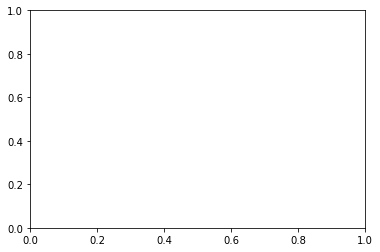

In [116]:
# Plot distirbution
sns.histplot(data=lyrics_data, x='sentiment')
plt.show()

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: The artist with the highest sentiment value per song is Robyn with an average value of 8.2. Due to this score, we see it moving in a more positive location. 

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: A lot of this music's lyrics seem to feature more upbeat words. It is possible that this is the reason that the sentiment score is up. 

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: As before, the sentiment score could be driven by the words being used in the lyrics. 

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [120]:
# your code here
positive_emojis = ['😊', '😄', '🙂', '😍', '👍', '🥳', '💃', '🌟', '✨', '🎉']
negative_emojis = ['😔', '😞', '😢', '😒', '👎', '😠', '😕', '😣', '😭', '🙁']

print(positive_emojis)
print(negative_emojis)

['😊', '😄', '🙂', '😍', '👍', '🥳', '💃', '🌟', '✨', '🎉']
['😔', '😞', '😢', '😒', '👎', '😠', '😕', '😣', '😭', '🙁']


In [121]:
emojis_sentiment = dict(zip(positive_emojis, [1]*10))
emojis_sentiment.update(dict(zip(negative_emojis, [-1]*10)))

In [122]:
emojis_sentiment

{'😊': 1,
 '😄': 1,
 '🙂': 1,
 '😍': 1,
 '👍': 1,
 '🥳': 1,
 '💃': 1,
 '🌟': 1,
 '✨': 1,
 '🎉': 1,
 '😔': -1,
 '😞': -1,
 '😢': -1,
 '😒': -1,
 '👎': -1,
 '😠': -1,
 '😕': -1,
 '😣': -1,
 '😭': -1,
 '🙁': -1}

In [125]:
# Filter artist
first_artist_data = lyrics_data[lyrics_data['artist'] == first_artist]
second_artist_data = lyrics_data[lyrics_data['artist'] == second_artist]

# Calculate average sentiment
first_artist_avg_sentiment = first_artist_data[first_artist_data['lyrics'].str.contains('|'.join(positive_emojis))]['sentiment'].mean()
second_artist_avg_sentiment = second_artist_data[second_artist_data['lyrics'].str.contains('|'.join(positive_emojis))]['sentiment'].mean()

# Print the average sentiment
print("Average Sentiment Robyn using Positive Emojis:", first_artist_avg_sentiment)
print("Average Sentiment Cher using Positive Emojis:", second_artist_avg_sentiment)


Average Sentiment Robyn using Positive Emojis: nan
Average Sentiment Cher using Positive Emojis: nan


Q: What is the average sentiment of your two artists? 

A: <!-- Your answer here --> 

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: <!-- Your answer here --> 


### References